# Demo 1: Single Layer Perceptron 
This demo we will demo code for using Perceptron model to solve the classification problem:
-   Problem: Defect detection classification (with the NEU surface defect dataset)
-   Dataset: NEU surface defect dataset <http://faculty.neu.edu.cn/songkechen/zh_CN/zhym/263269/list/index.htm>(NEU SDD)
-   Library packages:
    -   Numpy (Numpy arrays are very fast and can perform large computations in a very short time)
    -   PIL (Simple image processing package: read, show, resize,...)
    -   Matplotlib (Plot package: visualize result,....)
    -   TensorFlow (This is an open-source library that is used for DL/ML/AI)
    -   Scikit-Learn (Machine Learning models: KNN,SVM,Decision Tree, Metrics,...)
Tasks Outlines:
## 0. Task 0: Preparing dataset
-   Downloads dataset, unpacking dataset,...
-   Transform it to input (features) and ouput (labels) where the model in Scikit-Learn can read, and training on,...
-   Normalize or standardlize dataset (we may do it after some evaluations on the raw data)
-   Devide dataset to trainset and testset (maybe one more validation_set)
## 1. Task 1: Constructing model by using TensorFlow library:
-   Create a single layer perceptron model
-   Training model on our trainset
## 2. Task 2: Evaluating the performance of trained model on the testset
-   Predict the label (which class) for each input image in the testset
-   Compute the metrics (quantitative measurements) 
    -   For example on Classification task: Accuracy, Precesion, Recall, Confusion Matrix, F1-Score, Cross-Entropy Loss,...
## 3. Task 3: Hyper parameter tuning
-   Applying the "early stopping", "model check point" and "reduce learning rate on plateau" during the training step
*****************************************************************************

# Import all packages

In [2]:

import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


## 0. Task 0: Preparing Dataset

Go to the notebook file: Demo_Read_NEU_dataset.ipynb to get detail of demo code for this step

### 0.1. Define a function get all paths to each image in the dataset and the class label of each image

In [3]:
def get_all_img_label_path(input_dir:str,
                            img_suffix = '.bmp')->(list,list):
    """
    parameters:
    -   input_dir: the directory to the data folder
    -   img_suffix: siffix type of image in the data folder to read
    output: a tuple of two lists:
    -   List of all path to each image in the data folder
    -   List of relative class for each image in the data folder
    """
    label_to_number = {"Cr":0,"In":1,"Pa":2,"PS":3,"RS":4,"Sc":5}
    list_img_paths = []
    list_labels = []
    for root,dirs,files in os.walk(input_dir):
        for file in files:
            file_name,file_suffix = os.path.splitext(file)
            if file_suffix == img_suffix:
                list_img_paths.append(os.path.join(root,file))
                list_labels.append(label_to_number[file_name[:2]])
    return (list_img_paths,list_labels)


### 0.2. Define a function to get all image array and its class label (which are in type np.array)
In this function we also resize the all image to the same new size = (width, height)

In [4]:
# Resize the image to small dimensional of width and height
def get_data(list_img_paths:list,
             list_labels:list,
             is_resize:bool= True,
             width:int = 8,
             height:int = 8) -> (np.array,np.array):
    """
    Parameters:
    -   list_img_paths: List of all paths to image in the data folder
    -   list_labels: The list of labels relative to each image in the list_img_paths
    -   is_resize: Default is True means resize all image in the dataset
        to the new size (width,height)
    -   width: The width size which we want to resize to
    -   height: The height size which we want to resize to

    Output: A tuple of two arrays
    -   data_array with shape (N,h,w), where
        -   N is the number of image
        -   h is the height
        -   w is the width
    -   label_array with shape (N,)
    """
    data = []
    for i in range(len(list_img_paths)):
        path_img = list_img_paths[i]
        img = Image.open(path_img)
        if is_resize:
            img = img.resize(size = (width,height),
                            resample=Image.BICUBIC)
        data.append(np.array(img))
    return (np.array(data),np.array(list_labels))

### 0.3. Getting data by using two previouse function

In [5]:
# Get the list of all path to images, and the list of relative labels
dir_NEUCLS = "/Users/user/Victor2023/Dataset/NEU-CLS"
list_img_paths,list_labels = get_all_img_label_path(input_dir=dir_NEUCLS,
                                                    img_suffix='.bmp')

width = 128
height = 128
X,y = get_data(list_img_paths=list_img_paths,
               list_labels=list_labels,
               is_resize=True,
               width=width,
               height= height)

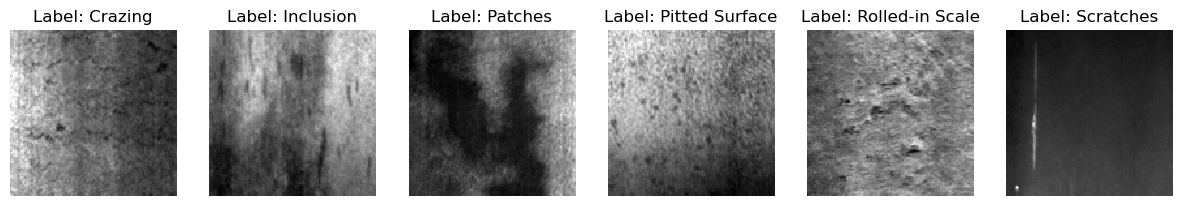

In [6]:
# Plotting some images to take an overview of our dataset
index_to_label = ["Crazing","Inclusion","Patches","Pitted Surface","Rolled-in Scale","Scratches"]
# Visualize one sample of each class
_, indices = np.unique(y,return_index=True) # get one index of each class
# Plot
_, axes = plt.subplots(nrows = 1,
                       ncols = len(indices),
                       figsize = (15,6))
for i in range(len(indices)):
    index = indices[i]
    axes[i].set_axis_off()
    axes[i].imshow(X[index], cmap = plt.cm.gray, interpolation= "nearest")
    axes[i].set_title(f"Label: {index_to_label[y[index]]}")

### Note!
The shape of data for KNN model should be (N_samples,N_features). In which:
-   N_samples: The total number of samples we have (number of images)
-   N_features: the number of features in each sample

Back to our data:
-   Data is image in grayscale we resize to same size (width,height), here is 128 x 128 pixels. Each pixels is one feature of sample, so totally we have 128*128 number of features for each sample.
-   We have to reshape our data from (N_samples,height,width) to (N_samples,height * width)


In [7]:
print("The currently shape of input dataset X is:", X.shape)

The currently shape of input dataset X is: (1800, 128, 128)


In [8]:
n_samples = X.shape[0]
X = X.reshape((n_samples,-1))
# Scaling feature from range [0,255] to range [0,1]
# Each pixel is a feature of input image, which has normally value in range [0,255] 
X = X/255
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# Convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)


In [9]:
print("The currently shape of input dataset X is:", X.shape)
print("The currently shape of dummy y is:", dummy_y.shape)


The currently shape of input dataset X is: (1800, 16384)
The currently shape of dummy y is: (1800, 6)


### 0.4. Deviding our dataset to trainset, validset and testset

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,dummy_y,test_size=0.1,shuffle=False)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,shuffle=False)

In [28]:
print("Number of samples in the train subset:", len(y_train))
print("Number of samples in the train subset:", len(y_val))
print("Number of samples in the test subset:", len(y_test))

Number of samples in the train subset: 1296
Number of samples in the train subset: 324
Number of samples in the test subset: 180


## 1. Task 1: Constructing model by using TensorFlow library:

### 1.1. Creating a single layer perceptron model
The perceptron operation:

$$output = activation(dot(input,kernel)+ bias)$$

In [32]:
# Creating a perceptron model:
dim_output = 6
input_shape = (X.shape[1],)
perceptron = keras.Sequential([
    keras.layers.Dense(dim_output,
                       input_shape = input_shape,
                       activation = 'sigmoid')
    ])

In [33]:
# Show the model summary
perceptron.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6)                 98310     
                                                                 
Total params: 98,310
Trainable params: 98,310
Non-trainable params: 0
_________________________________________________________________


-   The input shape is 16384
-   The output shape is 6
-   The weight shape (kernel) is (16284,6)
-   The bias shape is 6
-   The total parameters is: $16248*6+6 = 98310$

### 1.2. Train model

In [34]:
epochs = 150
optimizer = 'adam'
loss = keras.losses.CategoricalCrossentropy()
q_metrics = [keras.metrics.CategoricalAccuracy()]
perceptron.compile(optimizer=optimizer,
                   loss = loss,
                   metrics=q_metrics)
history = perceptron.fit(X_train,y_train,
                         batch_size=32,
                         epochs = epochs,
                         validation_data=(X_val,y_val),
                         verbose=2)

Epoch 1/150
41/41 - 1s - loss: 4.0295 - categorical_accuracy: 0.1929 - val_loss: 1.8005 - val_categorical_accuracy: 0.2099 - 772ms/epoch - 19ms/step
Epoch 2/150
41/41 - 0s - loss: 1.8269 - categorical_accuracy: 0.2762 - val_loss: 1.8394 - val_categorical_accuracy: 0.2099 - 175ms/epoch - 4ms/step
Epoch 3/150
41/41 - 0s - loss: 1.9745 - categorical_accuracy: 0.2870 - val_loss: 1.8597 - val_categorical_accuracy: 0.2407 - 192ms/epoch - 5ms/step
Epoch 4/150
41/41 - 0s - loss: 1.9152 - categorical_accuracy: 0.3063 - val_loss: 2.0884 - val_categorical_accuracy: 0.2438 - 168ms/epoch - 4ms/step
Epoch 5/150
41/41 - 0s - loss: 1.9216 - categorical_accuracy: 0.3179 - val_loss: 2.1004 - val_categorical_accuracy: 0.2037 - 159ms/epoch - 4ms/step
Epoch 6/150
41/41 - 0s - loss: 2.0005 - categorical_accuracy: 0.3063 - val_loss: 2.0246 - val_categorical_accuracy: 0.2469 - 221ms/epoch - 5ms/step
Epoch 7/150
41/41 - 0s - loss: 2.0933 - categorical_accuracy: 0.2986 - val_loss: 3.7423 - val_categorical_accur

In [15]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


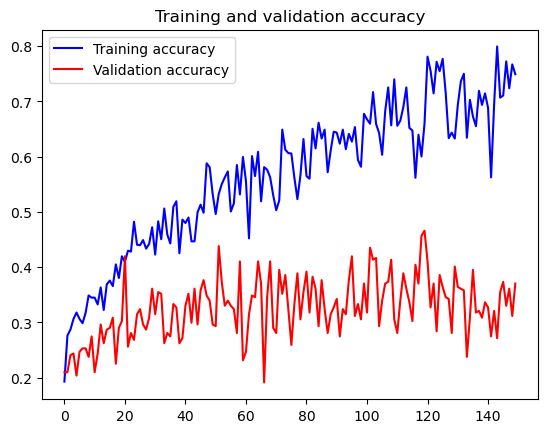

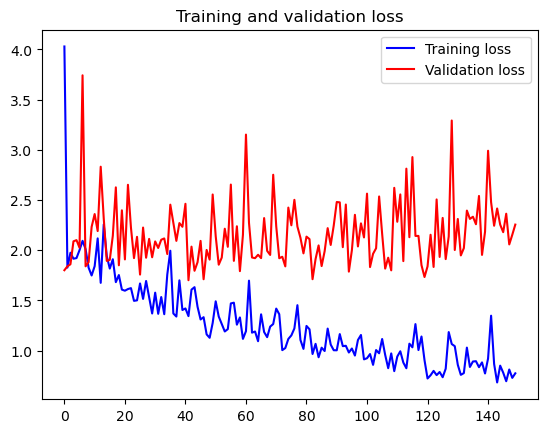

In [35]:
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 2. Task 2: Evaluating the performance of trained model on the testset

### 2.1. Predict the label (which class) for each input image in the testset

In [36]:
output_test = perceptron.predict(X_test)

6/6 [==============================] - 0s 4ms/step


In [37]:
pred_test = np.argmax(output_test,axis=-1)
truth_test = np.argmax(y_test,axis=-1)

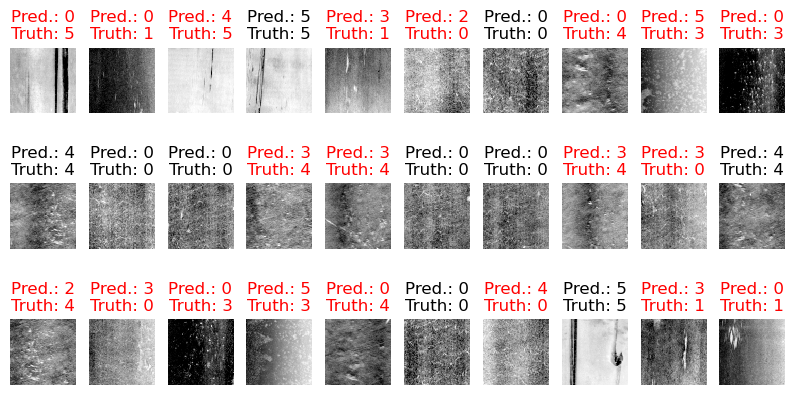

In [38]:
# Visualize the first 30 test samples and show their predicted digit value in the title.
_,axes = plt.subplots(nrows = 3,ncols = 10, figsize= (10,5))
for r in range(3):
    for c in range(10):
        index = r*10 + c
        axes[r,c].set_axis_off()
        image = X_test[index].reshape((width,height))
        pred_label = pred_test[index]
        true_label = truth_test[index]
        axes[r,c].imshow(image, cmap = plt.cm.gray_r, interpolation = "nearest")
        if pred_label == true_label:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}")
        else:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}",color = 'red')

### 2.2. Compute the metrics (quantitative measurements)

Text(0.5, 0.98, 'Number occurrences of each class on test set')

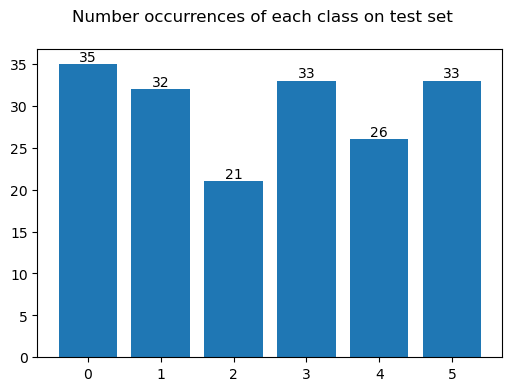

In [59]:
nb_classes = len(np.unique(truth_test))
## Visual bar plot of number occurrences of each class in testset:
statistic_class = np.unique(truth_test,return_counts=True)
categoricalClasses = [f'{C}' for C in statistic_class[0]]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.bar(x = categoricalClasses, height = statistic_class[1],width = 0.8)
for i in range(nb_classes):
    ax.text(categoricalClasses[i],statistic_class[1][i],
            str(statistic_class[1][i]),ha='center',va = 'bottom')
fig.suptitle("Number occurrences of each class on test set")

In [40]:
# Classification report:
print(f"Classification report for classifier {perceptron}:\n"
      f"{metrics.classification_report(truth_test,pred_test,digits=4)}\n")

Classification report for classifier <keras.engine.sequential.Sequential object at 0x15bfa3670>:
              precision    recall  f1-score   support

           0     0.2879    0.5429    0.3762        35
           1     0.0000    0.0000    0.0000        32
           2     0.4667    0.3333    0.3889        21
           3     0.1143    0.1212    0.1176        33
           4     0.1875    0.2308    0.2069        26
           5     0.5806    0.5455    0.5625        33

    accuracy                         0.3000       180
   macro avg     0.2728    0.2956    0.2754       180
weighted avg     0.2649    0.3000    0.2731       180




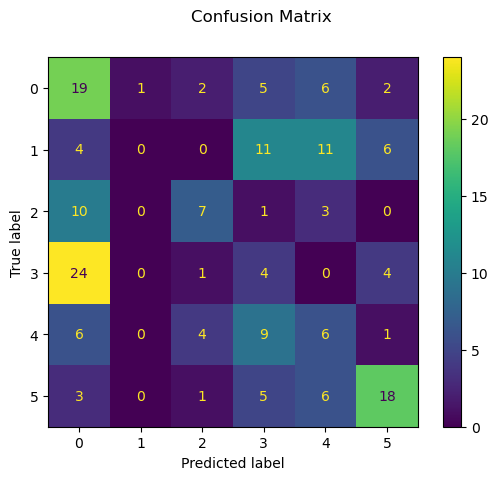

In [41]:
# Confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(truth_test,pred_test)
disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

## 3. Task 3: Hyper parameter tuning
-   Applying the "early stopping", "model check point" and "reduce learning rate on plateau" during the training step
    -   Early stopping is a method that allows us to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset
    -   Model check point callback is used to save a model or weights at some interval. Here we will use it to save the best model until early stopping training
    -   Reduce Learning Rate On Plateau it used for reduce learning rate when a metric has stopped improving.

### 3.1. Define EarlyStopping, ModelCheckpoint, ReduceLearningRateOnPlateau.

In [50]:
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=30)
mc = ModelCheckpoint('best_model.h5',
                     monitor='val_accuracy',
                     mode='max',
                     verbose=1,
                     save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=30,
                              min_lr=0.0001)

### 3.2. Define a perceptron

In [51]:
# Creating a perceptron model:
dim_output = 6
input_shape = (X.shape[1],)
perceptron1 = keras.Sequential([
    keras.layers.Dense(dim_output,
                       input_shape = input_shape,
                       activation = 'sigmoid')
    ])

In [52]:
# Show the model summary
perceptron1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6)                 98310     
                                                                 
Total params: 98,310
Trainable params: 98,310
Non-trainable params: 0
_________________________________________________________________


In [53]:
epochs = 500
optimizer = 'adam'
loss = keras.losses.CategoricalCrossentropy()
q_metrics = ['accuracy']
perceptron1.compile(optimizer=optimizer,
                   loss = loss,
                   metrics=q_metrics)
history = perceptron1.fit(X_train,y_train,
                         batch_size=32,
                         epochs = epochs,
                         validation_data=(X_val,y_val),
                         verbose=2,
                         callbacks=[es,mc,reduce_lr])

Epoch 1/500

Epoch 1: val_accuracy improved from -inf to 0.26543, saving model to best_model.h5
41/41 - 1s - loss: 4.5094 - accuracy: 0.1937 - val_loss: 2.1065 - val_accuracy: 0.2654 - lr: 0.0010 - 583ms/epoch - 14ms/step
Epoch 2/500

Epoch 2: val_accuracy improved from 0.26543 to 0.29321, saving model to best_model.h5
41/41 - 0s - loss: 1.9427 - accuracy: 0.2338 - val_loss: 1.7079 - val_accuracy: 0.2932 - lr: 0.0010 - 179ms/epoch - 4ms/step
Epoch 3/500

Epoch 3: val_accuracy did not improve from 0.29321
41/41 - 0s - loss: 1.9394 - accuracy: 0.2762 - val_loss: 1.9510 - val_accuracy: 0.2191 - lr: 0.0010 - 429ms/epoch - 10ms/step
Epoch 4/500

Epoch 4: val_accuracy did not improve from 0.29321
41/41 - 0s - loss: 1.8717 - accuracy: 0.2901 - val_loss: 1.9211 - val_accuracy: 0.2593 - lr: 0.0010 - 500ms/epoch - 12ms/step
Epoch 5/500

Epoch 5: val_accuracy did not improve from 0.29321
41/41 - 0s - loss: 1.7277 - accuracy: 0.3279 - val_loss: 2.0863 - val_accuracy: 0.2531 - lr: 0.0010 - 297ms/ep

In [54]:
output1_test = perceptron1.predict(X_test)
pred1_test = np.argmax(output1_test,axis=-1)
truth_test = np.argmax(y_test,axis=-1)

6/6 [==============================] - 0s 3ms/step


In [57]:
# Classification report:
print(f"Classification report for classifier {perceptron1}:\n"
      f"{metrics.classification_report(truth_test,pred1_test,digits=4)}\n")

Classification report for classifier <keras.engine.sequential.Sequential object at 0x15afbb100>:
              precision    recall  f1-score   support

           0     0.2143    0.2571    0.2338        35
           1     0.2703    0.6250    0.3774        32
           2     1.0000    0.1905    0.3200        21
           3     0.0000    0.0000    0.0000        33
           4     0.2188    0.2692    0.2414        26
           5     0.6429    0.5455    0.5902        33

    accuracy                         0.3222       180
   macro avg     0.3910    0.3146    0.2938       180
weighted avg     0.3558    0.3222    0.2929       180




/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

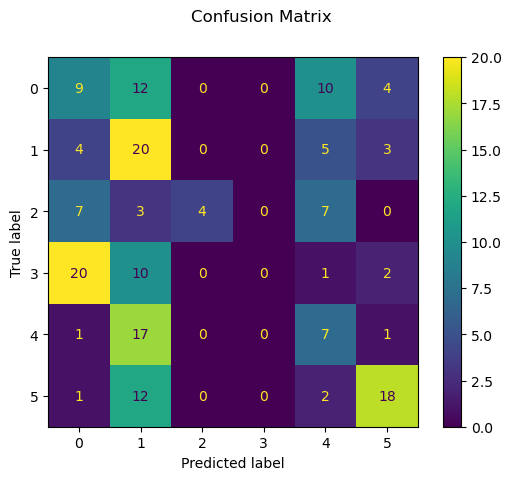

In [58]:
# Confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(truth_test,pred1_test)
disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()